# ECG Data Classification


## Summary :

for this project, we had to train a model to classify the heartbeat rate data of patients into 2 classes : sick ( -1 ) or healthy ( 1 ).
to do this, we had to train multiple models and choose the best one based on the recall score for the sick class.

the choice of using the recall score as the determining factor was due to the fact that we are more interested in the model's ability to correctly identify sick patients, as it is more important to identify a sick patient correctly than to identify a healthy one.

Recall is the ratio of correctly predicted positive observations to the all observations in actual class. The question recall answers is: Of all the sick people, how many did we label as sick?

so, if we want to never miss a sick patient, we should aim for a recall score of 1 for the sick class.

## Most important cells : 
**Run these next few cells to be able to test our best model on the test data.**

**The best model has been KNN**


the rest of the notebook is just the process of training and testing the models and evaluating them. 

In [ ]:
path_to_test_data = 'ECG200_TEST.txt' # set the path to the test data here. i set a placeholder.
path_to_train_data = 'ECG200_TRAIN.txt'

### set up the environment to run the model on the test data :

In [ ]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

columns = ['Class'] + [f'Time_{i}' for i in range(1, 97)]

**define all functions needed to run the model on the test data.**

In [ ]:
def min_max(training_data):
    global_max = training_data.values.max()
    global_min = training_data.values.min()
    return global_max, global_min

def preprocess_train_data(train_data_path):
    # Load the train data
    train_dataframe = pd.read_csv(train_data_path, delimiter='\s+', header=None, names=columns)
    
    X = train_dataframe.drop('Class', axis=1)
    y = train_dataframe['Class']

    global_max, global_min = min_max(X)

    # Normalize the data
    X_normalized = (X - global_min) / (global_max - global_min)

    train_dataframe[X.columns] = X_normalized

    return train_dataframe, global_max, global_min

def preprocess_test_data(test_data_path, global_max, global_min):
    # Load the test data
    test_data = pd.read_csv(test_data_path, delimiter='\s+', header=None, names=columns)
    
    X_test = test_data.drop('Class', axis=1)
    y = test_data['Class']

    # Normalize the data
    X_normalized_test = (X_test - global_min) / (global_max - global_min)

    test_data[X_test.columns] = X_normalized_test

    return test_data


def train_model(training_data_path):
    df, global_max, global_min = preprocess_train_data(training_data_path)

    # Split the data into features and labels
    X_train = df.drop(['Class'], axis=1)
    y_train = df['Class']

    knn_clf = KNeighborsClassifier(n_neighbors=2)

    # Fit the model
    knn_clf.fit(X_train, y_train)

    return knn_clf, global_max, global_min


def predict_test_data(test_data_path, training_data_path):
    # Train the model and get global min and max
    model, global_max, global_min = train_model(training_data_path)

    # Preprocess the test data
    df = preprocess_test_data(test_data_path, global_max, global_min)

    # Split the data into features and labels
    X_test = df.drop(['Class'], axis=1)
    y_true = df['Class']

    # Predict using the KNN model
    y_pred = model.predict(X_test)

    print('Test Data Predictions:')
    print(y_pred)

    # Evaluate the model
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Test Accuracy: {accuracy:.2f}')

### This is the cell that will output the vector of classification. 
if the paths are well set, the output will be the vector of classification for the test data using the K-Nearest Neighbors model.

In [ ]:
predict_test_data(path_to_test_data, path_to_train_data)

--------------------------------------------------------------------------------------------

## The rest of the notebook is the process of training and testing the models and evaluating them.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder

from keras import Sequential
from keras.layers import Dense, Dropout

from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

from tensorflow.keras.layers import  LSTM

2024-06-10 21:13:49.661358: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-10 21:13:49.661941: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-10 21:13:49.665462: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-10 21:13:49.714309: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-10 21:13:50.677090: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

In [ ]:

def lstm_model(X_train, y_train):
    # Reshape the data for RNN
    X_train_rnn = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
    X_test_rnn = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

    # Convert class labels to integers
    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train)
    y_test_encoded = le.transform(y_test)

    # Define the RNN model with LSTM layers
    model_rnn = Sequential([
        LSTM(units=50, return_sequences=True, input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])),
        Dropout(0.2),
        LSTM(units=50, return_sequences=True),
        Dropout(0.2),
        LSTM(units=50),
        Dropout(0.2),
        Dense(units=1, activation='sigmoid')
    ])

    # Compile the model
    model_rnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model_rnn.fit(X_train_rnn, y_train_encoded, epochs=50, batch_size=32, validation_split=0.2)

    # Evaluate the model
    loss, accuracy = model_rnn.evaluate(X_test_rnn, y_test_encoded)
    print(f"LSTM Model Test Loss: {loss:.4f}")
    print(f"LSTM Model Test Accuracy: {accuracy:.4f}")



    # Predict probabilities
    y_prob_rnn = model_rnn.predict(X_test_rnn)
    # Threshold probabilities to get classes
    y_pred_rnn = np.where(y_prob_rnn > 0.5, 1, 0)

    # Print classification report
    print("Classification Report for LSTM Model:")
    print(classification_report(y_test_encoded, y_pred_rnn))



    # Calculate precision, recall, and F1-score
    precision_rnn = precision_score(y_test_encoded, y_pred_rnn)
    recall_rnn = recall_score(y_test_encoded, y_pred_rnn)
    f1_rnn = f1_score(y_test_encoded, y_pred_rnn)


    # Calculate AUC for LSTM model
    auc_rnn = roc_auc_score(y_test_encoded, y_prob_rnn)



    # Print precision, recall, and F1-score for LSTM model
    print("Precision for LSTM Model:", precision_rnn)
    print("Recall for LSTM Model:", recall_rnn)
    print("F1-score for LSTM Model:", f1_rnn)

    # Print AUC for LSTM model
    print("AUC for LSTM Model:", auc_rnn)


    return accuracy, precision_rnn, recall_rnn, f1_rnn, auc_rnn


In [ ]:
def  simple_neural_network(X_train, y_train):
    # Convert class labels to integers
    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train)
    y_test_encoded = le.transform(y_test)

    # Define the neural network model without LSTM
    model_nn = Sequential([
        Dense(units=64, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(0.2),
        Dense(units=32, activation='relu'),
        Dropout(0.2),
        Dense(units=1, activation='sigmoid')
    ])

    # Compile the model
    model_nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model_nn.fit(X_train, y_train_encoded, epochs=50, batch_size=32, validation_split=0.2)

    # Evaluate the model
    loss, accuracy = model_nn.evaluate(X_test, y_test_encoded)
    print(f"NN Model Test Loss: {loss:.4f}")
    print(f"NN Model Test Accuracy: {accuracy:.4f}")


    # Predict probabilities
    y_prob_nn = model_nn.predict(X_test)
    # Threshold probabilities to get classes
    y_pred_nn = np.where(y_prob_nn > 0.5, 1, 0)

    # Print classification report
    print("Classification Report for NN Model:")
    print(classification_report(y_test_encoded, y_pred_nn))



    # Calculate precision, recall, and F1-score
    precision_nn = precision_score(y_test_encoded, y_pred_nn)
    recall_nn = recall_score(y_test_encoded, y_pred_nn)
    f1_nn = f1_score(y_test_encoded, y_pred_nn)


    # Calculate AUC for simple neural network model
    auc_nn = roc_auc_score(y_test_encoded, y_prob_nn)


    # Print precision, recall, and F1-score for simple neural network model
    print("Precision for NN Model:", precision_nn)
    print("Recall for NN Model:", recall_nn)
    print("F1-score for NN Model:", f1_nn)


    # Print AUC for simple neural network model
    print("AUC for NN Model:", auc_nn)

    return accuracy, precision_nn, recall_nn, f1_nn, auc_nn




In [ ]:
def plot_roc_curve(fpr, tpr, roc_auc):
    # Plot ROC curve
    plt.figure(figsize=(4, 4))
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()


def plot_confusion_matrix(confusion_matrix):
    # Visualize confusion matrix
    plt.figure(figsize=(4, 4))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

In [ ]:
def performance_metrics(precision_scores, recall_scores, f1_scores, auc_scores):
    # Plot the evaluation metrics
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Performance Metrics of Different Models', fontsize=16)

    # Precision
    axes[0, 0].bar(precision_scores.keys(), precision_scores.values(), color='skyblue')
    axes[0, 0].set_title('Precision')
    axes[0, 0].set_ylabel('Precision')
    axes[0, 0].tick_params(axis='x', rotation=45)

    # Recall
    axes[0, 1].bar(recall_scores.keys(), recall_scores.values(), color='lightgreen')
    axes[0, 1].set_title('Recall')
    axes[0, 1].set_ylabel('Recall')
    axes[0, 1].tick_params(axis='x', rotation=45)

    # F1-score
    axes[1, 0].bar(f1_scores.keys(), f1_scores.values(), color='salmon')
    axes[1, 0].set_title('F1-score')
    axes[1, 0].set_ylabel('F1-score')
    axes[1, 0].tick_params(axis='x', rotation=45)

    # AUC
    axes[1, 1].bar(auc_scores.keys(), auc_scores.values(), color='lightcoral')
    axes[1, 1].set_title('AUC')
    axes[1, 1].set_ylabel('AUC')
    axes[1, 1].tick_params(axis='x', rotation=45)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


<h2>Importing the data and transform it into DataFrame</h2>

In [ ]:
columns = ['Class'] + [f'Time_{i}' for i in range(1, 97)]

df = pd.read_csv('ECG200_TRAIN.txt', delimiter='\s+', header=None, names=columns)

df

,Class,Time_1,Time_2,Time_3,Time_4,Time_5,Time_6,Time_7,Time_8,Time_9,...,Time_87,Time_88,Time_89,Time_90,Time_91,Time_92,Time_93,Time_94,Time_95,Time_96
0,-1.0,0.502055,0.542163,0.722383,1.428885,2.136516,2.281149,1.936274,1.468890,1.008845,...,0.931043,0.610298,0.638894,0.684679,0.583238,0.640522,0.708585,0.705011,0.713815,0.433765
1,1.0,0.147647,0.804668,0.367771,0.243894,0.026614,-0.274402,0.096731,-0.747731,-1.609777,...,-0.533503,-0.400228,0.176084,1.111768,2.438428,2.734889,1.736054,0.036857,-1.265074,-0.208024
2,-1.0,0.316646,0.243199,0.370471,1.063738,1.678187,1.759558,1.697717,1.612159,1.168188,...,0.764229,0.610621,0.552900,0.566786,0.604002,0.777068,0.812345,0.748848,0.818042,0.539347
3,-1.0,1.168874,2.075901,1.760141,1.606446,1.949046,1.302842,0.459332,0.516412,0.852180,...,0.419006,0.723888,1.323947,2.136488,1.746597,1.470220,1.893512,1.256949,0.800407,0.731540
4,1.0,0.648658,0.752026,2.636231,3.455716,2.118157,0.520620,-0.188627,0.780818,0.933775,...,-0.097869,-0.136787,-0.340237,-0.089441,-0.080297,-0.192584,-0.304704,-0.454556,0.314590,0.582190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1.0,0.581277,0.876188,1.042767,1.796120,2.541399,2.246653,1.500387,1.031521,0.382672,...,1.002770,0.907869,0.916457,0.923975,0.767357,0.656223,0.762357,0.501373,-0.333336,-0.524546
96,-1.0,2.689017,2.708703,2.008381,2.235800,1.516982,0.029916,-0.561346,-0.793702,-0.979371,...,-0.136610,-0.072176,-0.082738,-0.138468,-0.120396,-0.089411,-0.243141,-0.119710,0.124042,0.273463
97,-1.0,0.197677,0.455417,0.973110,1.935956,2.259463,1.741341,1.158296,0.418241,-0.071605,...,0.482452,0.325569,0.247991,0.184127,0.050358,0.241988,0.331451,-0.120006,0.042423,0.343293
98,1.0,0.179500,1.038409,1.946421,2.705141,1.670706,-0.101167,-1.578876,-0.750906,0.175310,...,0.324323,0.330489,0.111953,0.448948,0.567132,0.136757,0.444768,0.151050,0.193378,0.451709


<h2>Class distribution</h2>

In [ ]:
class_distribution = df['Class'].value_counts()
print(class_distribution)

Class
 1.0    69
-1.0    31
Name: count, dtype: int64


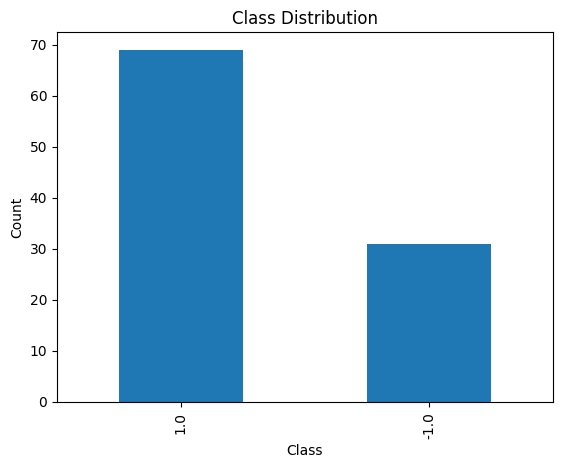

In [ ]:
# Plot the class distribution
class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

<h5>This distribution indicates that the dataset is imbalanced, with more instances of normal heartbeats (class 1.0) compared to myocardial infarctions (class -1.0). An imbalanced dataset can affect the performance of machine learning models, often leading to a model that is biased towards the majority class.</h5>

<h2>Handling missing values</h2>

In [ ]:
missing_values = df.isnull().sum()
print("Missing Values:\n", missing_values)

Missing Values:
 Class      0
Time_1     0
Time_2     0
Time_3     0
Time_4     0
          ..
Time_92    0
Time_93    0
Time_94    0
Time_95    0
Time_96    0
Length: 97, dtype: int64


In [ ]:
df.fillna(df.mean(), inplace=True)

<h2>Verifying the features of the data</h2>

In [ ]:
df.describe()

,Class,Time_1,Time_2,Time_3,Time_4,Time_5,Time_6,Time_7,Time_8,Time_9,...,Time_87,Time_88,Time_89,Time_90,Time_91,Time_92,Time_93,Time_94,Time_95,Time_96
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.380000,0.708438,1.422151,2.039149,2.126455,1.551616,0.762251,0.282647,0.333630,0.372973,...,0.190412,0.174286,0.205107,0.286484,0.412464,0.459377,0.389852,0.282864,0.182829,0.174863
std,0.929646,0.593513,0.927972,1.046880,1.098754,0.954734,0.963111,1.096712,0.877640,0.761753,...,0.403825,0.434002,0.454395,0.589879,0.772104,0.871045,0.832312,0.665548,0.619799,0.413644
min,-1.000000,-0.706305,-1.100715,-1.321589,-1.076313,-1.247922,-1.482391,-1.598712,-1.508060,-1.609777,...,-0.533503,-0.691436,-0.516631,-0.574304,-0.559178,-0.530917,-0.738019,-0.970796,-1.862314,-1.238622
25%,-1.000000,0.318643,0.779810,1.525548,1.511639,0.966292,0.022470,-0.603378,-0.464767,-0.075355,...,-0.131730,-0.140244,-0.121657,-0.144015,-0.070247,-0.098634,-0.107719,-0.119784,-0.124178,-0.043105
50%,1.000000,0.581008,1.232191,2.152552,2.234408,1.746861,0.574297,0.120230,0.366122,0.457255,...,0.086719,0.089474,0.107957,0.129133,0.170798,0.205220,0.101618,0.136106,0.124148,0.152284
75%,1.000000,0.994760,2.093703,2.707411,2.865394,2.163355,1.502335,1.226563,1.008876,0.990675,...,0.439861,0.468588,0.480635,0.613990,0.588429,0.630966,0.560136,0.594807,0.541680,0.429055
max,1.000000,2.689017,3.535038,3.850263,4.199145,3.720899,3.026452,2.454195,2.220327,2.122435,...,1.376751,1.497244,1.436900,2.190151,3.047309,3.269882,3.332053,2.653741,1.930880,1.372607


<h2>Spltting the df</h2>

In [ ]:
X = df.drop('Class', axis=1)
y = df['Class']

<h2>Normalizing the data</h2>

we used min max scaling to normalize all the columns in an equal manner.

In [ ]:
global_max = X.values.max()
global_min = X.values.min()

X_normalized = (X - global_min) / (global_max - global_min)

In [ ]:
df[X.columns] = X_normalized

In [ ]:
df.describe()

,Class,Time_1,Time_2,Time_3,Time_4,Time_5,Time_6,Time_7,Time_8,Time_9,...,Time_87,Time_88,Time_89,Time_90,Time_91,Time_92,Time_93,Time_94,Time_95,Time_96
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.380000,0.487890,0.592596,0.683114,0.695922,0.611590,0.495784,0.425423,0.432903,0.438675,...,0.411892,0.409526,0.414048,0.425986,0.444468,0.451351,0.441151,0.425455,0.410779,0.409611
std,0.929646,0.087072,0.136140,0.153584,0.161195,0.140066,0.141295,0.160895,0.128756,0.111754,...,0.059244,0.063671,0.066663,0.086539,0.113273,0.127788,0.122106,0.097640,0.090929,0.060684
min,-1.000000,0.280338,0.222475,0.190071,0.226055,0.200879,0.166480,0.149415,0.162715,0.147792,...,0.305689,0.282519,0.308164,0.299703,0.301922,0.306068,0.275685,0.241535,0.110743,0.202243
25%,-1.000000,0.430704,0.498361,0.607765,0.605725,0.525719,0.387254,0.295438,0.315773,0.372902,...,0.364631,0.363382,0.366109,0.362829,0.373651,0.369487,0.368154,0.366384,0.365739,0.377633
50%,1.000000,0.469195,0.564728,0.699751,0.711760,0.640233,0.468210,0.401596,0.437670,0.451040,...,0.396679,0.397084,0.399795,0.402902,0.409014,0.414064,0.398865,0.403925,0.402170,0.406298
75%,1.000000,0.529895,0.691118,0.781153,0.804330,0.701336,0.604360,0.563902,0.531966,0.529296,...,0.448488,0.452702,0.454470,0.474034,0.470284,0.476524,0.466133,0.471219,0.463425,0.446902
max,1.000000,0.778454,0.902571,0.948817,1.000000,0.929838,0.827958,0.744004,0.709694,0.695333,...,0.585936,0.603613,0.594760,0.705267,0.831018,0.863671,0.872792,0.773279,0.667230,0.585328


In [ ]:
X = df.drop('Class', axis=1)

<h2>Plotting some samples</h2>

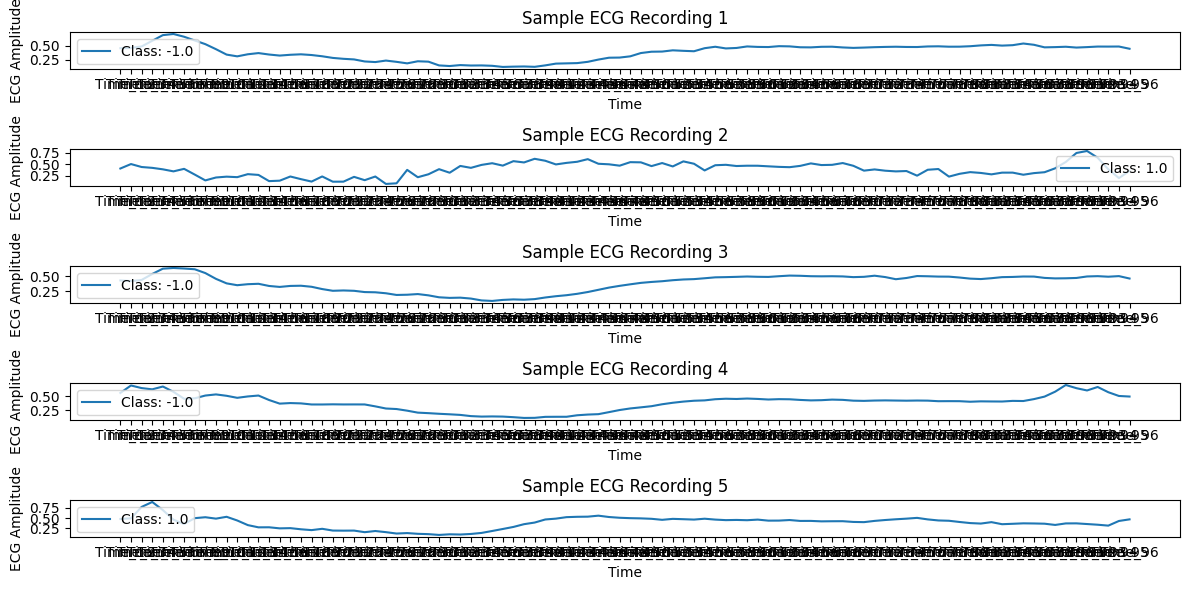

In [ ]:

num_samples_to_plot = 5

plt.figure(figsize=(12, 6))

for i in range(num_samples_to_plot):
    plt.subplot(num_samples_to_plot, 1, i + 1)
    plt.plot(X.iloc[i], label=f"Class: {y.iloc[i]}")
    plt.xlabel('Time')
    plt.ylabel('ECG Amplitude')
    plt.title(f'Sample ECG Recording {i+1}')
    plt.legend()

plt.tight_layout()
plt.show()


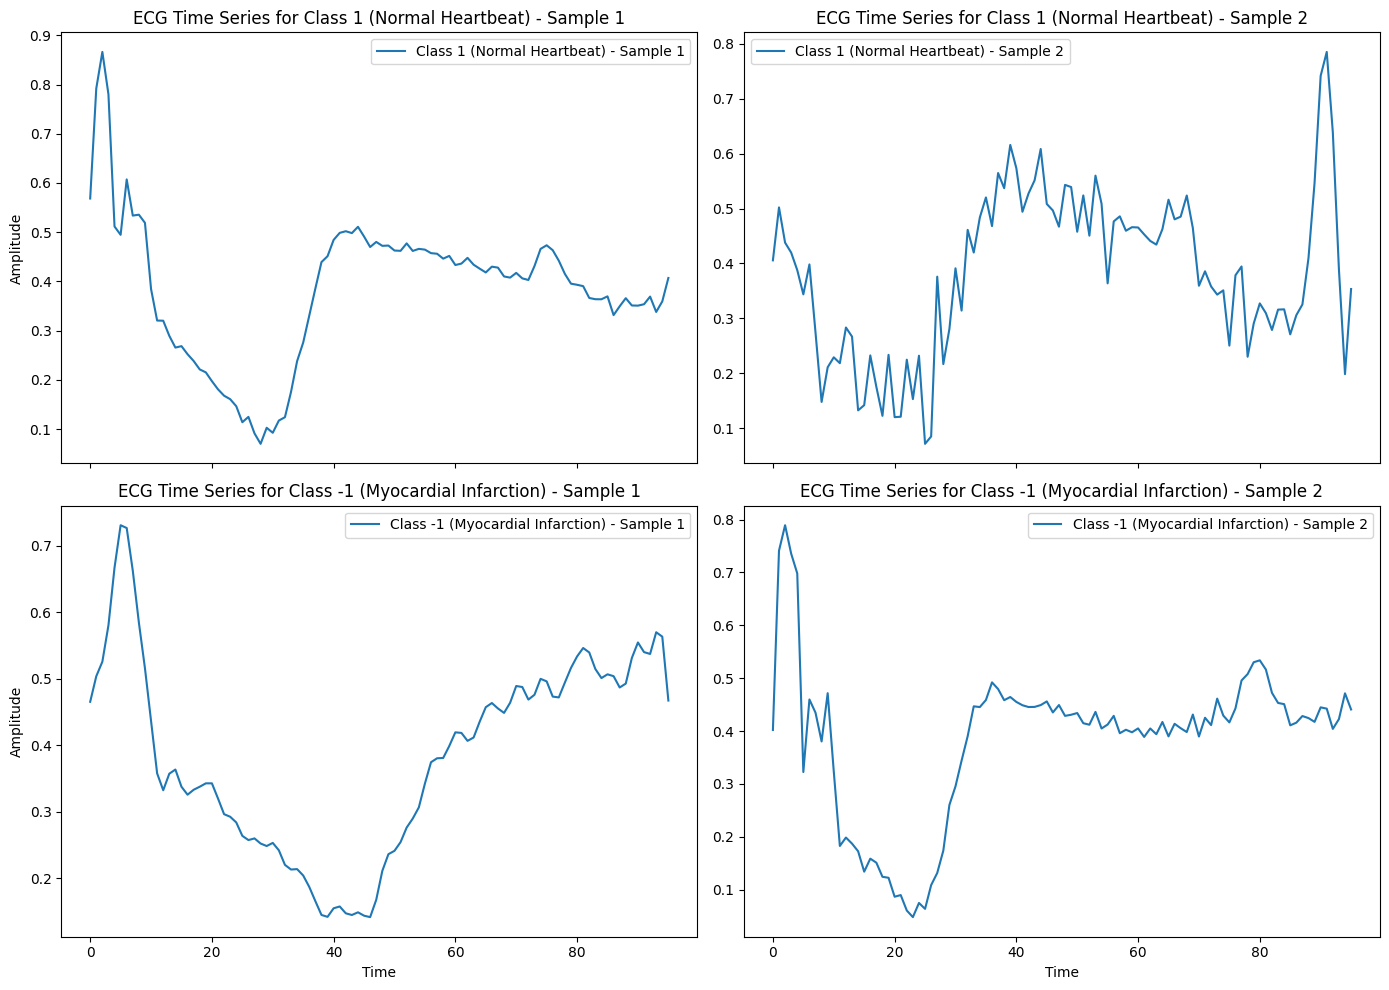

In [ ]:
# Separate data by class
df_class_1 = df[df['Class'] == 1]
df_class_minus_1 = df[df['Class'] == -1]

# Randomly select two samples from each class
samples_class_1 = df_class_1.sample(n=2, random_state=42).values
samples_class_minus_1 = df_class_minus_1.sample(n=2, random_state=42).values

# Extract the time series data (excluding the class label)
time_series_class_1_sample1 = samples_class_1[0, 1:]
time_series_class_1_sample2 = samples_class_1[1, 1:]
time_series_class_minus_1_sample1 = samples_class_minus_1[0, 1:]
time_series_class_minus_1_sample2 = samples_class_minus_1[1, 1:]

# Plot the time series data for each sample
fig, axs = plt.subplots(2, 2, figsize=(14, 10), sharex=True)

# Plot for Class 1
axs[0, 0].plot(time_series_class_1_sample1, label='Class 1 (Normal Heartbeat) - Sample 1')
axs[0, 0].set_title('ECG Time Series for Class 1 (Normal Heartbeat) - Sample 1')
axs[0, 0].set_ylabel('Amplitude')
axs[0, 0].legend()

axs[0, 1].plot(time_series_class_1_sample2, label='Class 1 (Normal Heartbeat) - Sample 2')
axs[0, 1].set_title('ECG Time Series for Class 1 (Normal Heartbeat) - Sample 2')
axs[0, 1].legend()

# Plot for Class -1
axs[1, 0].plot(time_series_class_minus_1_sample1, label='Class -1 (Myocardial Infarction) - Sample 1')
axs[1, 0].set_title('ECG Time Series for Class -1 (Myocardial Infarction) - Sample 1')
axs[1, 0].set_xlabel('Time')
axs[1, 0].set_ylabel('Amplitude')
axs[1, 0].legend()

axs[1, 1].plot(time_series_class_minus_1_sample2, label='Class -1 (Myocardial Infarction) - Sample 2')
axs[1, 1].set_title('ECG Time Series for Class -1 (Myocardial Infarction) - Sample 2')
axs[1, 1].set_xlabel('Time')
axs[1, 1].legend()

plt.tight_layout()
plt.show()

<h2>Splitting the data</h2>

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<h2>Class distribution in training set</h2>

In [ ]:
class_distribution_train = pd.Series(y_train).value_counts()
print("Class distribution in the training set: ")
print(class_distribution_train)

Class distribution in the training set: 
Class
 1.0    55
-1.0    25
Name: count, dtype: int64


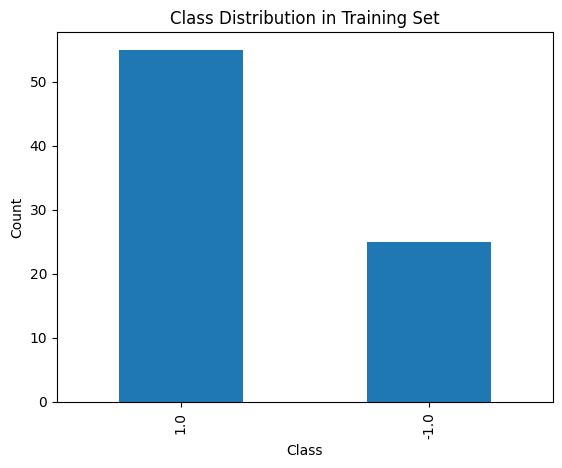

In [ ]:
class_distribution_train.plot(kind="bar")
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution in Training Set')
plt.show()

<h5> this class distribution indicates an imbalance in the training set. There are significantly more instances of normal heartbeats (Class 1.0) than instances of myocardial infarctions (Class -1.0).</h5>

<h1> MODELS </h1>

<h1>Random Forest</h1>

Classification Report:
               precision    recall  f1-score   support

        -1.0       0.67      0.67      0.67         6
         1.0       0.86      0.86      0.86        14

    accuracy                           0.80        20
   macro avg       0.76      0.76      0.76        20
weighted avg       0.80      0.80      0.80        20



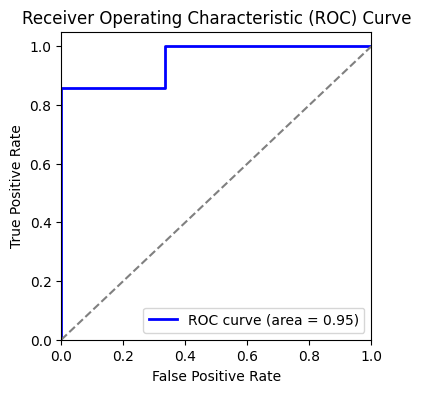

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_y_pred = rf.predict(X_test)
print("Classification Report:\n", classification_report(y_test, rf_y_pred))

rf_y_pred_proba = rf.predict_proba(X_test)[:, 1]

rf_fpr, rf_tpr, thresholds = roc_curve(y_test, rf_y_pred_proba)
rf_roc_auc = auc(rf_fpr, rf_tpr)

plot_roc_curve(rf_fpr, rf_tpr, rf_roc_auc)


<H1>KNN</H1>

KNN Classification Report:
               precision    recall  f1-score   support

        -1.0       1.00      0.67      0.80         6
         1.0       0.88      1.00      0.93        14

    accuracy                           0.90        20
   macro avg       0.94      0.83      0.87        20
weighted avg       0.91      0.90      0.89        20



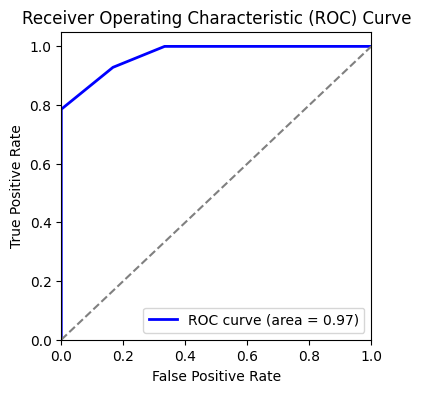

In [ ]:
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)
knn_y_pred = knn_model.predict(X_test)
print("KNN Classification Report:\n", classification_report(y_test, knn_y_pred))

knn_y_pred_proba = knn_model.predict_proba(X_test)[:, 1]

knn_fpr, knn_tpr, thresholds = roc_curve(y_test, knn_y_pred_proba)
knn_roc_auc = auc(knn_fpr, knn_tpr)

plot_roc_curve(knn_fpr, knn_tpr, knn_roc_auc)

<h1>Logistic Regression</h1>

Logistic Regression Classification Report:
               precision    recall  f1-score   support

        -1.0       0.67      0.33      0.44         6
         1.0       0.76      0.93      0.84        14

    accuracy                           0.75        20
   macro avg       0.72      0.63      0.64        20
weighted avg       0.74      0.75      0.72        20



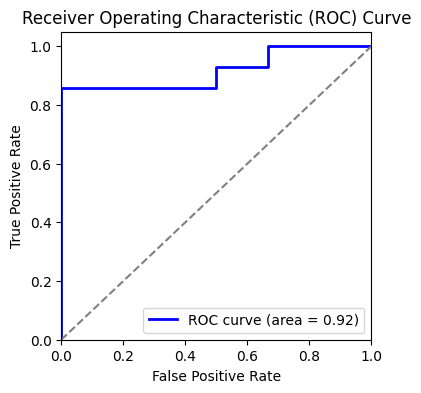

In [ ]:
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)
logistic_y_pred = logistic_model.predict(X_test)
print("Logistic Regression Classification Report:\n", classification_report(y_test, logistic_y_pred))


lr_y_pred_proba = logistic_model.predict_proba(X_test)[:, 1]

lr_fpr, lr_tpr, thresholds = roc_curve(y_test, lr_y_pred_proba)
lr_roc_auc = auc(lr_fpr, lr_tpr)

plot_roc_curve(lr_fpr, lr_tpr, lr_roc_auc)


<h1>SVM</h1>

SVM Classification Report:
               precision    recall  f1-score   support

        -1.0       0.75      0.50      0.60         6
         1.0       0.81      0.93      0.87        14

    accuracy                           0.80        20
   macro avg       0.78      0.71      0.73        20
weighted avg       0.79      0.80      0.79        20



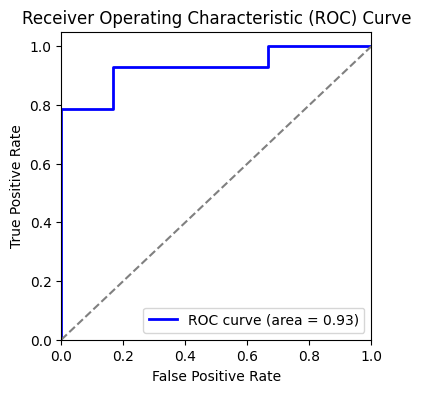

In [ ]:
svm_model = SVC(probability=True)
svm_model.fit(X_train, y_train)
svm_y_pred = svm_model.predict(X_test)
print("SVM Classification Report:\n", classification_report(y_test, svm_y_pred))


svm_y_pred_proba = svm_model.predict_proba(X_test)[:, 1]

svm_fpr, svm_tpr, thresholds = roc_curve(y_test, svm_y_pred_proba)
svm_roc_auc = auc(svm_fpr, svm_tpr)

plot_roc_curve(svm_fpr, svm_tpr, svm_roc_auc)

<h1>AdaBoost</h1>

/home/moon/anaconda3/envs/lab1/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost Classification Report:
               precision    recall  f1-score   support

        -1.0       0.83      0.83      0.83         6
         1.0       0.93      0.93      0.93        14

    accuracy                           0.90        20
   macro avg       0.88      0.88      0.88        20
weighted avg       0.90      0.90      0.90        20



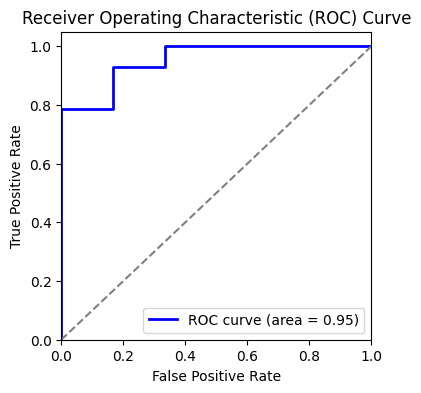

In [ ]:
ada_boost_model = AdaBoostClassifier()
ada_boost_model.fit(X_train, y_train)
ada_boost_y_pred = ada_boost_model.predict(X_test)
print("AdaBoost Classification Report:\n", classification_report(y_test, ada_boost_y_pred))


adb_y_pred_proba = ada_boost_model.predict_proba(X_test)[:, 1]

adb_fpr, adb_tpr, thresholds = roc_curve(y_test, adb_y_pred_proba)
adb_roc_auc = auc(adb_fpr, adb_tpr)

plot_roc_curve(adb_fpr, adb_tpr, adb_roc_auc)

<h1>GradientBoost</h1>

Gradient Boosting Classification Report:
               precision    recall  f1-score   support

        -1.0       0.67      0.67      0.67         6
         1.0       0.86      0.86      0.86        14

    accuracy                           0.80        20
   macro avg       0.76      0.76      0.76        20
weighted avg       0.80      0.80      0.80        20



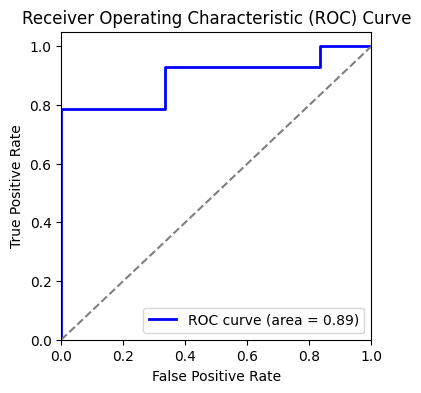

In [ ]:
gradient_boost_model = GradientBoostingClassifier()
gradient_boost_model.fit(X_train, y_train)
gradient_boost_y_pred = gradient_boost_model.predict(X_test)
print("Gradient Boosting Classification Report:\n", classification_report(y_test, gradient_boost_y_pred))


gb_y_pred_proba = gradient_boost_model.predict_proba(X_test)[:, 1]

gb_fpr, gb_tpr, thresholds = roc_curve(y_test, gb_y_pred_proba)
gb_roc_auc = auc(gb_fpr, gb_tpr)

plot_roc_curve(gb_fpr, gb_tpr, gb_roc_auc)

<h2> Handling class imbalance</h2>

In [ ]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to balance the classes in the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check the class distribution in the resampled training set
class_distribution_resampled = pd.Series(y_train_resampled).value_counts()
print("Class distribution in the resampled training set:")
print(class_distribution_resampled)

Class distribution in the resampled training set:
Class
 1.0    55
-1.0    55
Name: count, dtype: int64


<h2> Training the models after handling class imbalance</h2>

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

resampled_precision_scores = {}
resampled_recall_scores = {}
resampled_f1_scores = {}
resampled_auc_scores = {}

models = {
    "Random Forest": RandomForestClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Logistic Regression": LogisticRegression(),
    "Support Vector Machine": SVC(),
    "AdaBoost": AdaBoostClassifier(),
    "Gradient Boosting": GradientBoostingClassifier()
}

for name, model in models.items():
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)


    resampled_precision_scores[name] = precision
    resampled_recall_scores[name] = recall
    resampled_f1_scores[name] = f1
    resampled_auc_scores[name] = auc

/home/moon/anaconda3/envs/lab1/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


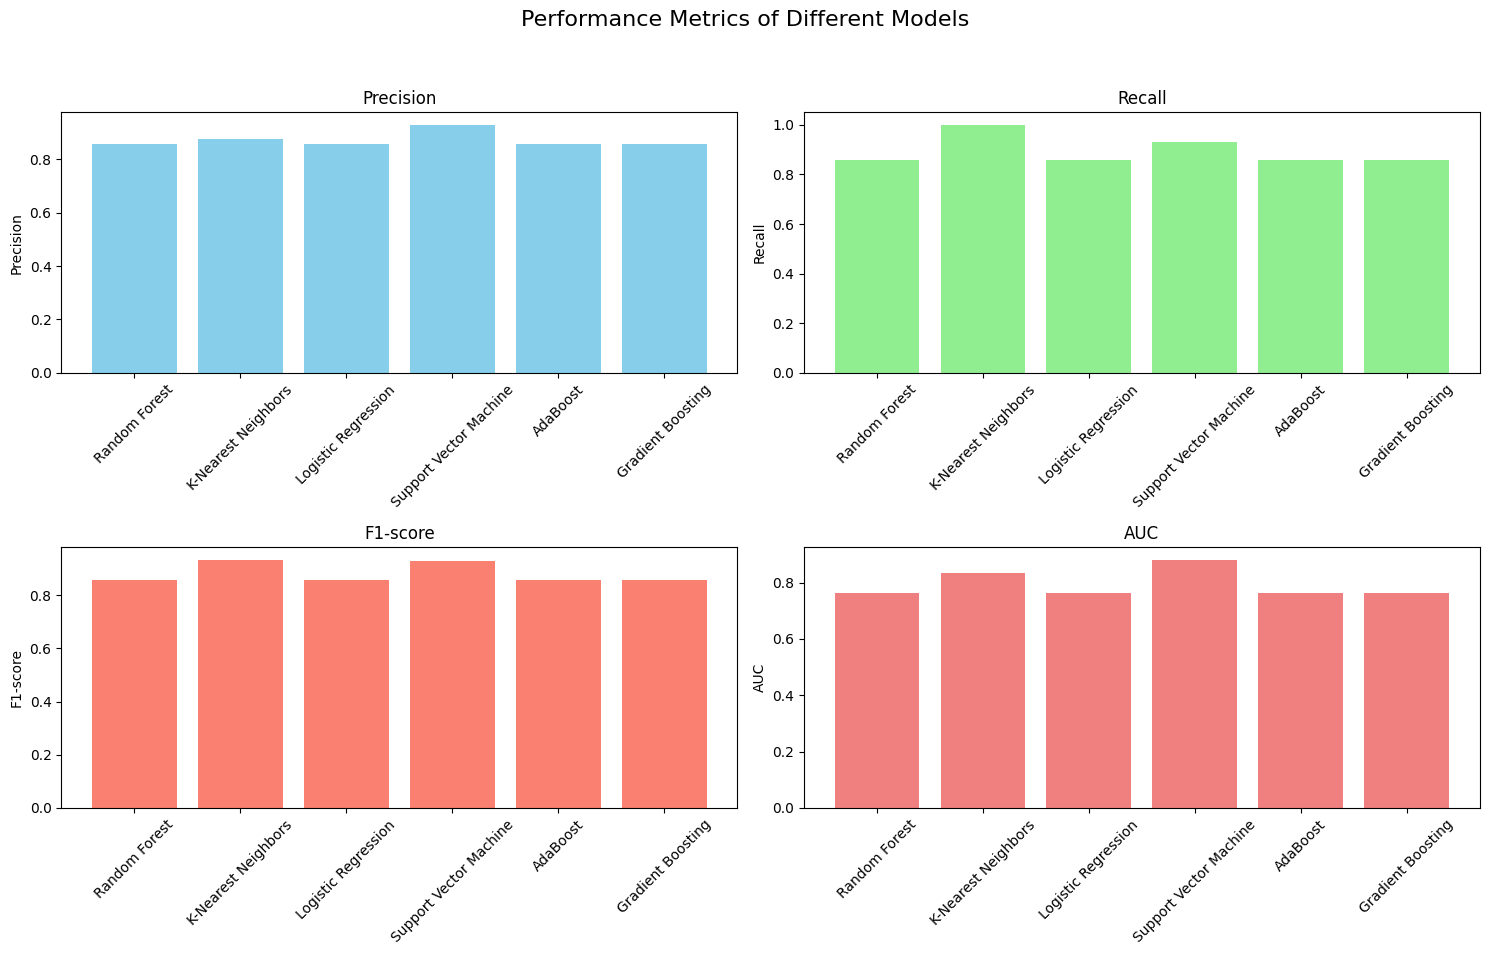

In [ ]:
performance_metrics(resampled_precision_scores, resampled_recall_scores, resampled_f1_scores, resampled_auc_scores)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

precision_scores = {}
recall_scores = {}
f1_scores = {}
auc_scores = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    precision_scores[name] = precision_score(y_test, y_pred)
    recall_scores[name] = recall_score(y_test, y_pred)
    f1_scores[name] = f1_score(y_test, y_pred)
    auc_scores[name] = roc_auc_score(y_test, y_pred)

/home/moon/anaconda3/envs/lab1/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


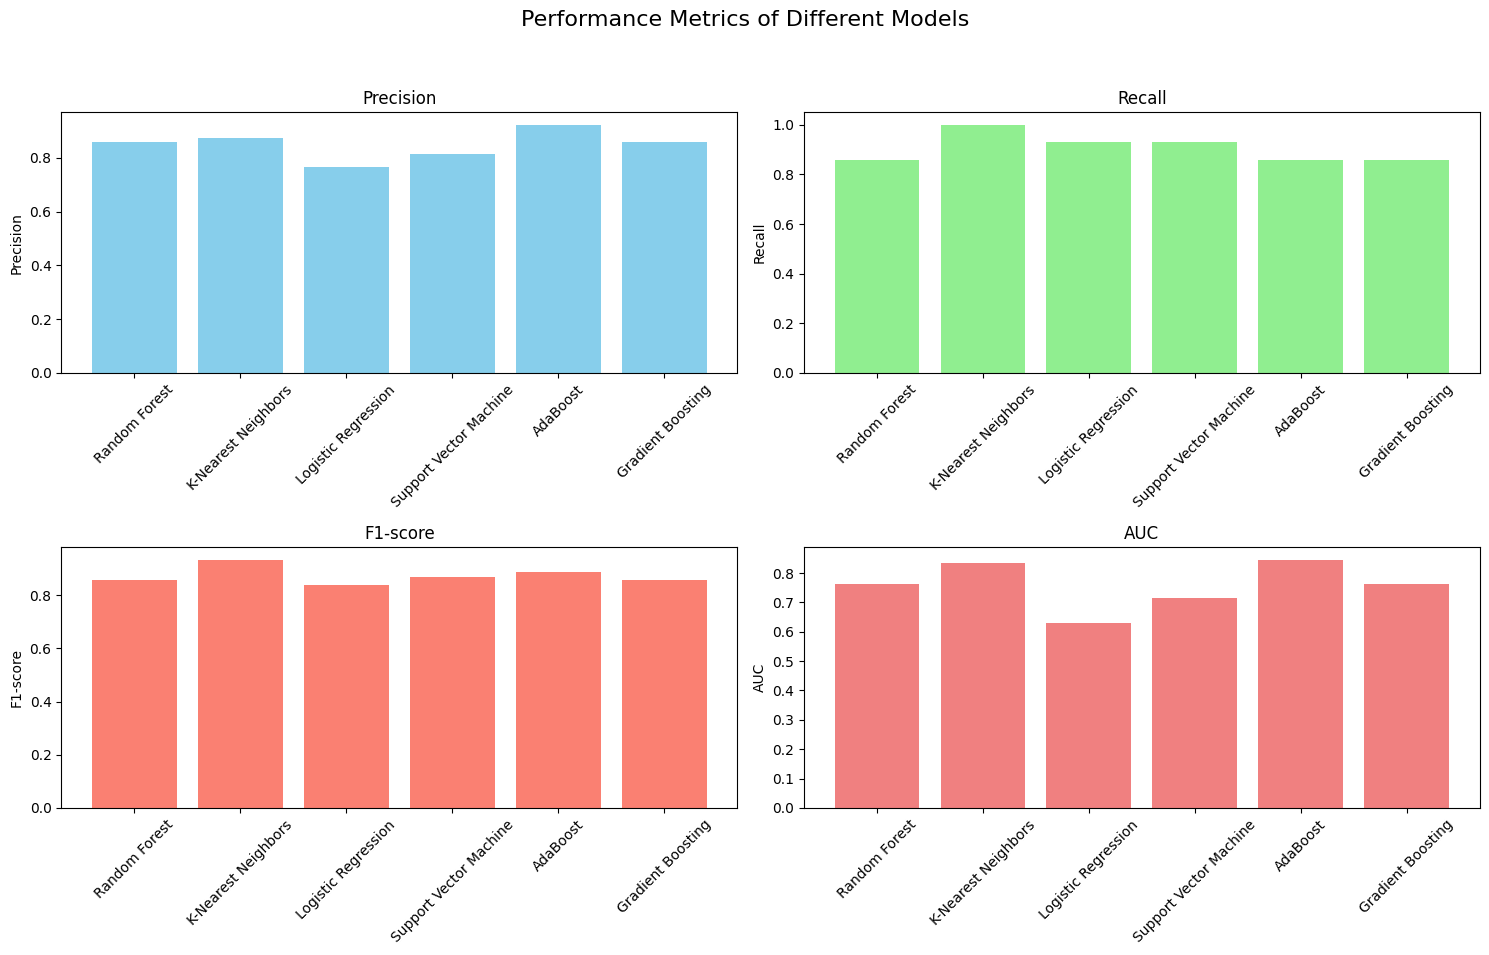

In [ ]:
performance_metrics(precision_scores, recall_scores, f1_scores, auc_scores )

<h5> - After applying resampling, we notice an improvement the performance of all the models overall, especially the Logistic Regression model where the recall for the negative class went from 0.33 to 0.67 as well as the f1_score that went from 0.44 to 0.67.
Beside the slight drop in the accuracy of  and Gradient Boosting model, its performance has improved  </h5>

<h5> - The Random Forest model performs better on the original data.</h5>

<h2> Deep Learning models</h2>

<h2> Simple Neural Network</h2>

<h3> Using original resampled data</h3>

In [ ]:
resampled_accuracy_nn, resampled_precision_nn, resampled_recall_nn, resampled_f1_score_nn, resampled_auc_nn = simple_neural_network(X_train_resampled, y_train_resampled)

Epoch 1/50


/home/moon/anaconda3/envs/lab1/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - accuracy: 0.4233 - loss: 0.7621 - val_accuracy: 0.7727 - val_loss: 0.6661
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4727 - loss: 0.7078 - val_accuracy: 0.0000e+00 - val_loss: 0.8502
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6197 - loss: 0.6577 - val_accuracy: 0.0000e+00 - val_loss: 0.9449
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6520 - loss: 0.6355 - val_accuracy: 0.0000e+00 - val_loss: 0.9395
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6928 - loss: 0.6264 - val_accuracy: 0.0000e+00 - val_loss: 0.9400
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6829 - loss: 0.6001 - val_accuracy: 0.0000e+00 - val_loss: 0.9079
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7099 - loss: 0.5884 - val_accuracy: 0.1364 - val_loss: 0.8688
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7134 - loss: 0.5680 - val_accuracy: 0.3182 - val_loss

<h3> Using original training data</h3>

In [ ]:
accuracy, precision_nn, recall_nn, f1_score_nn, auc_nn = simple_neural_network(X_train, y_train)


Epoch 1/50


/home/moon/anaconda3/envs/lab1/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - accuracy: 0.3021 - loss: 0.8298 - val_accuracy: 0.2500 - val_loss: 0.7402
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4583 - loss: 0.7335 - val_accuracy: 0.8125 - val_loss: 0.6603
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5417 - loss: 0.7012 - val_accuracy: 0.8125 - val_loss: 0.6114
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.6146 - loss: 0.6508 - val_accuracy: 0.7500 - val_loss: 0.5801
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6562 - loss: 0.6666 - val_accuracy: 0.7500 - val_loss: 0.5640
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6250 - loss: 0.6423 - val_accuracy: 0.7500 - val_loss: 0.5518
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6042 - loss: 0.6402 - val_accuracy: 0.7500 - val_loss: 0.5422
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6875 - loss: 0.6361 - val_accuracy: 0.7500 - val_loss: 0.5330
Epoch 9/50

<h2> LSTM</h2>

<h3> Using resampled training data</h3>

In [ ]:
resampled_accuracy_rnn, resampled_precision_rnn, resampled_recall_rnn, resampled_f1_score_rnn, resampled_auc_rnn = lstm_model(X_train_resampled, y_train_resampled)


Epoch 1/50


/home/moon/anaconda3/envs/lab1/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 263ms/step - accuracy: 0.4513 - loss: 0.6934 - val_accuracy: 0.0000e+00 - val_loss: 0.6987
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6094 - loss: 0.6918 - val_accuracy: 0.0000e+00 - val_loss: 0.7056
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6445 - loss: 0.6892 - val_accuracy: 0.0000e+00 - val_loss: 0.7138
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6250 - loss: 0.6875 - val_accuracy: 0.0000e+00 - val_loss: 0.7232
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6367 - loss: 0.6845 - val_accuracy: 0.0000e+00 - val_loss: 0.7358
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6328 - loss: 0.6814 - val_accuracy: 0.0000e+00 - val_loss: 0.7525
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5820 - loss: 0.6834 - val_accuracy: 0.0000e+00 - val_loss: 0.7714
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5859 - loss: 0.6785 - val_accuracy: 0.0000e+

In [ ]:
accuracy_rnn, precision_rnn, recall_rnn, f1_score_rnn, auc_rnn = lstm_model(X_train, y_train)

/home/moon/anaconda3/envs/lab1/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 536ms/step - accuracy: 0.6354 - loss: 0.6922 - val_accuracy: 0.7500 - val_loss: 0.6883
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6667 - loss: 0.6893 - val_accuracy: 0.7500 - val_loss: 0.6843
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6875 - loss: 0.6860 - val_accuracy: 0.7500 - val_loss: 0.6797
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6875 - loss: 0.6826 - val_accuracy: 0.7500 - val_loss: 0.6742
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6979 - loss: 0.6786 - val_accuracy: 0.7500 - val_loss: 0.6679
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.6667 - loss: 0.6770 - val_accuracy: 0.7500 - val_loss: 0.6606
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6562 - loss: 0.6743 - val_accuracy: 0.7500 - val_loss: 0.6522
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6979 - loss: 0.6619 - val_accuracy: 0.7500 - val_loss: 0.6422

In [ ]:
# Append precision, recall, and F1-score to the existing dictionaries
resampled_precision_scores['LSTM'] = resampled_precision_rnn
resampled_recall_scores['LSTM'] = resampled_recall_rnn
resampled_f1_scores['LSTM'] = resampled_f1_score_rnn
resampled_auc_scores['LSTM'] = resampled_auc_rnn

# Append precision, recall, and F1-score to the existing dictionaries
resampled_precision_scores['NN'] = resampled_precision_nn
resampled_recall_scores['NN'] = resampled_recall_nn
resampled_f1_scores['NN'] = resampled_f1_score_rnn
resampled_auc_scores['NN'] = resampled_auc_nn



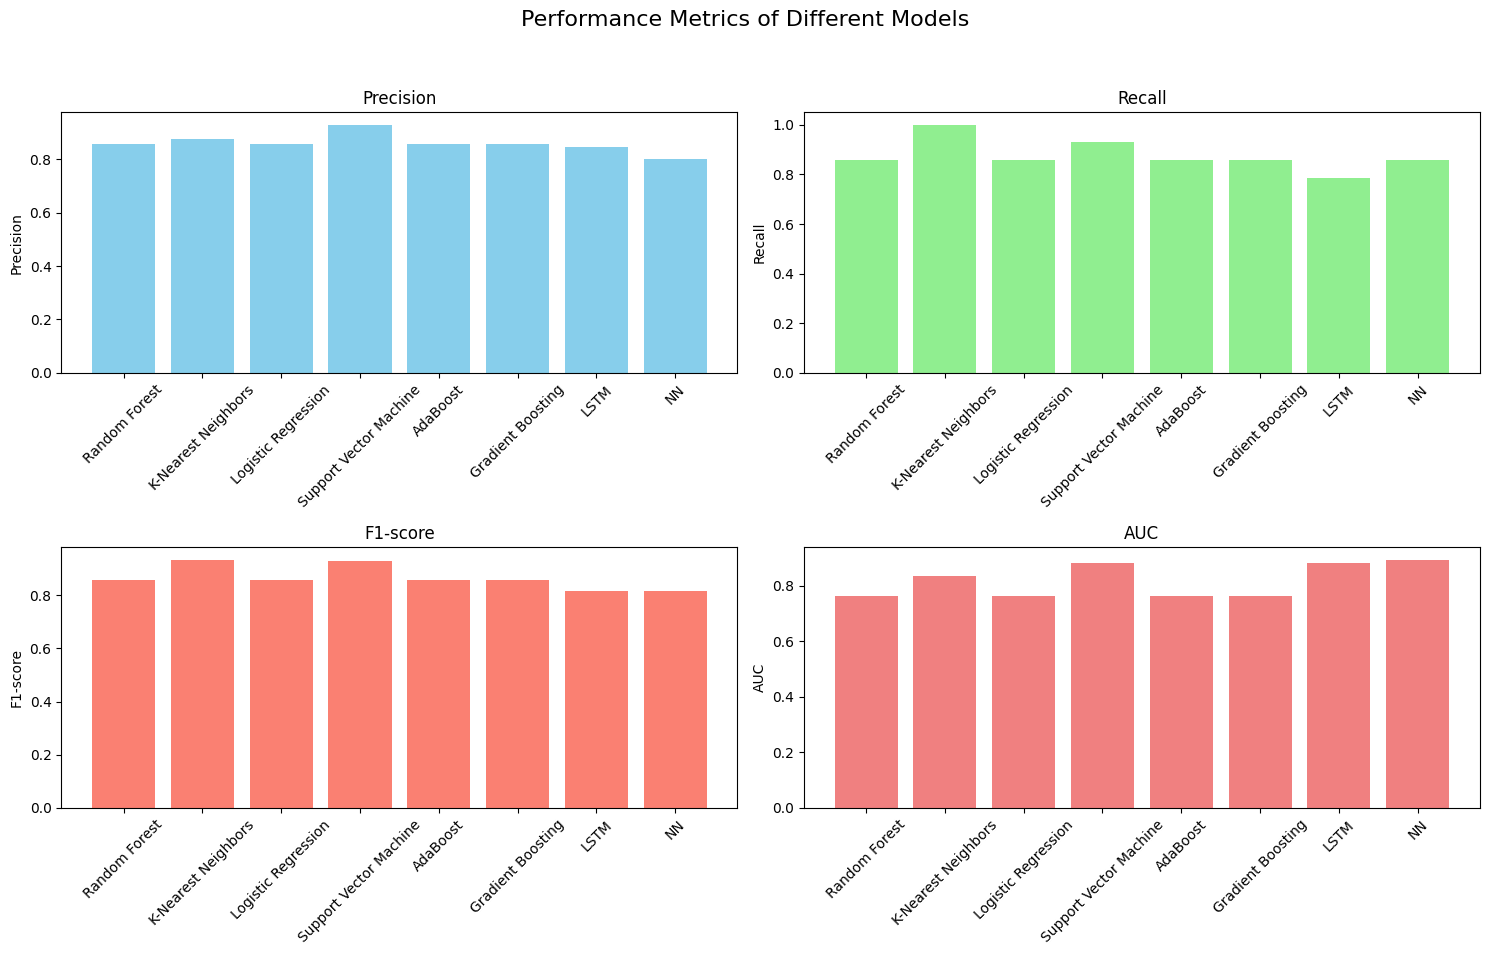

In [ ]:
performance_metrics(resampled_precision_scores, resampled_recall_scores, resampled_f1_scores, resampled_auc_scores)

In [ ]:
# Append precision, recall, and F1-score to the existing dictionaries
precision_scores['LSTM'] = precision_rnn
recall_scores['LSTM'] = recall_rnn
f1_scores['LSTM'] = f1_score_rnn
auc_scores['LSTM'] = auc_rnn


# Append precision, recall, and F1-score to the existing dictionaries
precision_scores['NN'] = precision_nn
recall_scores['NN'] = recall_nn
f1_scores['NN'] = f1_score_nn
auc_scores['NN'] = auc_nn





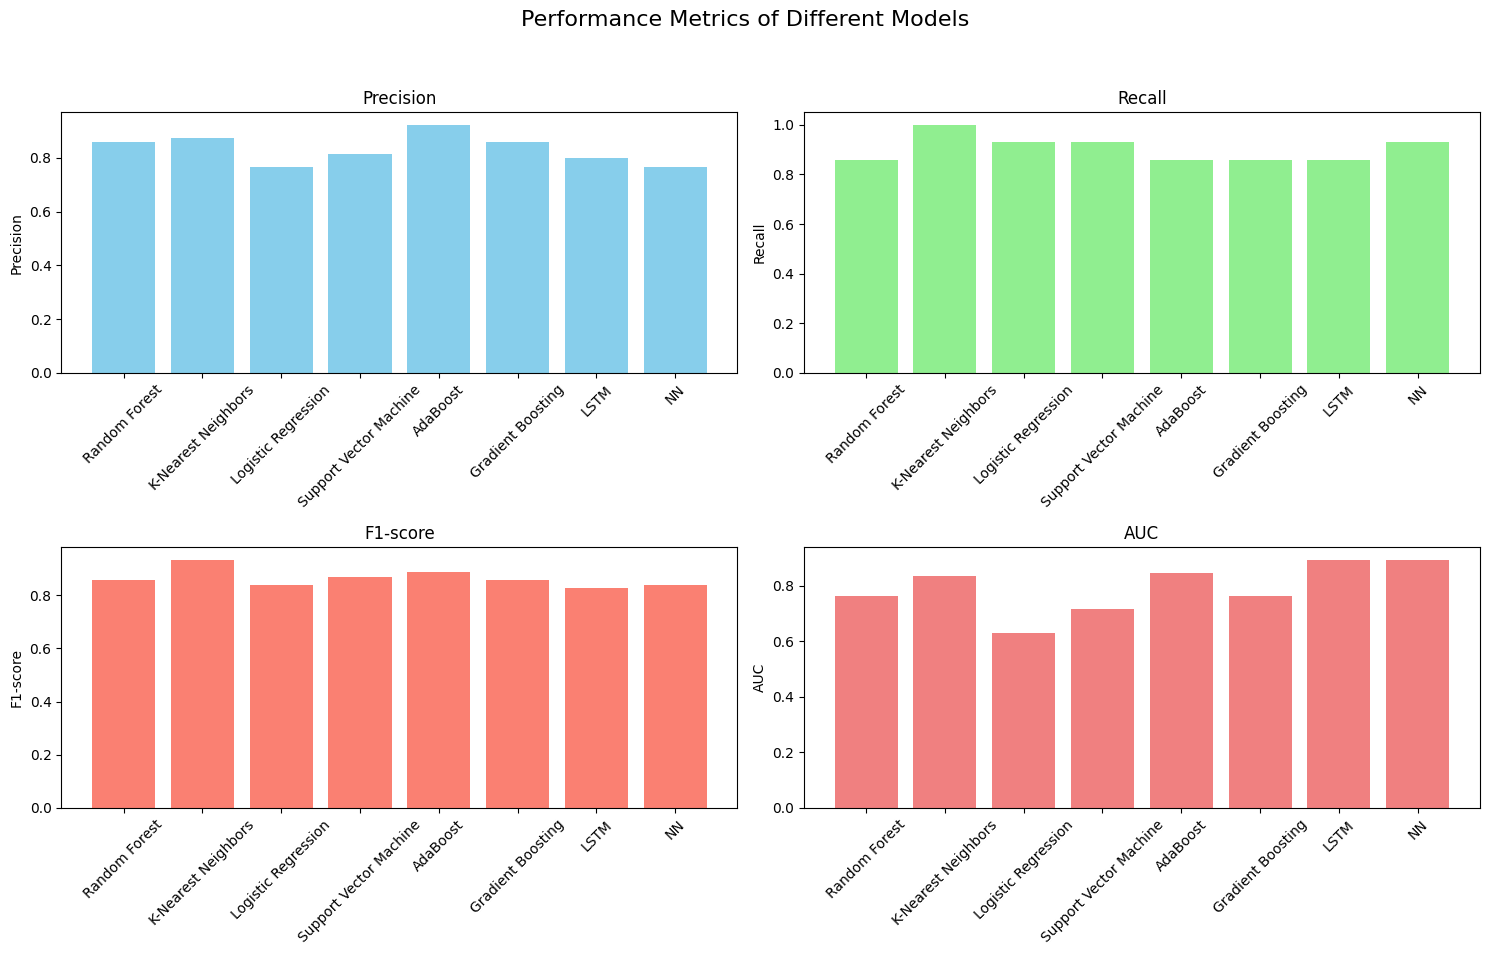

In [ ]:
performance_metrics(precision_scores, recall_scores, f1_scores, auc_scores)

# Feature Extraction and training new models.

# Fourier Transform:

Converts time series data to frequency components.
Captures the magnitude of frequencies up to a specified number of components.

Shapelet Transform:


Identifies discriminative subsequences (shapelets) in the time series.
Transforms data into a new feature space based on the distances to these shapelets.

In [ ]:
% pip install tslearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 2.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 20.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 MB 24.0 MB/s eta 0:00:0000:0100:01


Define the Fourier and Shapelet Transformation Function:

In [ ]:
import numpy as np
import pandas as pd

def fourier_transform(row, n_components=10):
    fft = np.fft.fft(row)
    fft = np.abs(fft)
    return fft[:n_components]

# Apply Fourier transformation to each row in the DataFrame
def apply_fourier_transform(df, n_components=10):
    fft_features = df.drop(columns=['Class']).apply(fourier_transform, axis=1, n_components=n_components)
    fft_df = pd.DataFrame(fft_features.tolist(), index=df.index)
    return pd.concat([df[['Class']], fft_df], axis=1)

df_fft = apply_fourier_transform(df, n_components=30)


In [ ]:
import numpy as np
import pandas as pd
from tslearn.shapelets import ShapeletModel, grabocka_params_to_shapelet_size_dict

# Assuming df is your DataFrame
X = df.drop(columns=['Class']).values.reshape(df.shape[0], df.shape[1] - 1, 1)
y = df['Class'].values

n_ts, ts_sz = X.shape[:2]
n_classes = len(np.unique(y))

# Set parameters for shapelets
shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=n_ts, ts_sz=ts_sz, n_classes=n_classes, l=0.1, r=1)

# Initialize and fit the ShapeletModel
shp_clf = ShapeletModel(n_shapelets_per_size=shapelet_sizes, optimizer="sgd", weight_regularizer=0.01, max_iter=200)
shp_clf.fit(X, y)

# Transform data
X_shapelet_transformed = shp_clf.transform(X)


/home/moon/anaconda3/envs/lab1/lib/python3.11/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


In [ ]:
# Combine FFT features and shapelet-transformed features
combined_features = np.hstack([df_fft.drop(columns=['Class']).values, X_shapelet_transformed])
y_combined = df['Class'].values


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(combined_features, y_combined, test_size=0.2, random_state=42)

# Fit RandomForest model and select features
model = RandomForestClassifier(n_estimators=100)
model.fit(X_train, y_train)

# Feature selection
selector = SelectFromModel(model, prefit=True)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

# Train the model with selected features
model_selected = RandomForestClassifier(n_estimators=100)
model_selected.fit(X_train_selected, y_train)

# Make predictions
y_pred = model_selected.predict(X_test_selected)

# Evaluate the performance
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')


Accuracy: 0.95


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# Fit the model
gbm = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbm.fit(X_train_selected, y_train)

# Make predictions
y_pred = gbm.predict(X_test_selected)

# Evaluate the performance
accuracy = accuracy_score(y_test, y_pred)
print(f'GBM Accuracy: {accuracy}')


GBM Accuracy: 0.85


In [ ]:
from sklearn.svm import SVC

# Fit the model
svm = SVC(kernel='rbf', C=1, gamma='scale', random_state=42)
svm.fit(X_train_selected, y_train)

# Make predictions
y_pred = svm.predict(X_test_selected)

# Evaluate the performance
accuracy = accuracy_score(y_test, y_pred)
print(f'SVM Accuracy: {accuracy}')


SVM Accuracy: 0.9


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Define the model
model = Sequential()
model.add(Dense(64, input_dim=X_train_selected.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model
model.fit(X_train_selected, y_train, epochs=50, batch_size=10, verbose=1)

# Evaluate the model
accuracy = model.evaluate(X_test_selected, y_test, verbose=0)[1]
print(f'Neural Network Accuracy: {accuracy}')


Epoch 1/50


/home/moon/anaconda3/envs/lab1/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0000e+00 - loss: 0.5196   
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0056 - loss: 0.3662     
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2056 - loss: 0.4715     
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3445 - loss: 0.4020 
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3652 - loss: 0.2701 
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3979 - loss: 0.1791  
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4831 - loss: 0.2971 
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3307 - loss: 0.0672 
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3476 - loss: 0.1020 
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3925 - loss: -0.2458 
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3531 - loss: -0.4702 
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4425 - loss: -0.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Fit the model
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train_selected, y_train)

# Make predictions
y_pred = knn.predict(X_test_selected)

# Evaluate the performance
accuracy = accuracy_score(y_test, y_pred)
print(f'k-NN Accuracy: {accuracy}')


k-NN Accuracy: 1.0


In [ ]:
from sklearn.linear_model import LogisticRegression

# Fit the model
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train_selected, y_train)

# Make predictions
y_pred = log_reg.predict(X_test_selected)

# Evaluate the performance
accuracy = accuracy_score(y_test, y_pred)
print(f'Logistic Regression Accuracy: {accuracy}')


Logistic Regression Accuracy: 0.8


# Conclusion
**High Baseline Accuracy:**

-All tested models, including RandomForest, Gradient Boosting Machines (GBM), Support Vector Machines (SVM), k-Nearest Neighbors (k-NN), and Logistic Regression, performed well with accuracies in the range of 0.8 to 0.9. Except for neural networks which had a 0.5 accuracy score

-This indicates that the time series data, after applying feature selection and transformation techniques ( Fourier transform and shapelet transform ), is effectively capturing the underlying patterns required for classification.

**Effective Feature Selection and Transformation:**

The combination of Fourier transform and shapelet transform for feature extraction appears to be beneficial. Both techniques have successfully transformed the time series data into a feature space where traditional machine learning models can perform well.